<a href="https://colab.research.google.com/github/sabeenasulthan/Time-series-LSTM-deep-learning-project/blob/main/LSTM_Project_py.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

ARIMA RMSE: 278.43830664327896
ARIMA MAE: 227.7861234946644
Epoch 1/100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


41/41 ━━━━━━━━━━━━━━━━━━━━ 7s 63ms/step - loss: 0.0643 - val_loss: 0.0057
Epoch 2/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - loss: 0.0041 - val_loss: 0.0014
Epoch 3/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0041 - val_loss: 6.0460e-04
Epoch 4/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - loss: 0.0039 - val_loss: 4.6642e-04
Epoch 5/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - loss: 0.0036 - val_loss: 0.0012
Epoch 6/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 0.0036 - val_loss: 8.7263e-04
Epoch 7/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0029 - val_loss: 7.7276e-04
Epoch 8/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - loss: 0.0028 - val_loss: 4.3542e-04
Epoch 9/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - loss: 0.0029 - val_loss: 6.4923e-04
Epoch 10/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - loss: 0.0027 - val_loss: 4.8789e-04
Epoch 11/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0030 - val_loss: 9.6551e-04
Epoch 12/100
41/41 ━━━━━━━━━━━━━

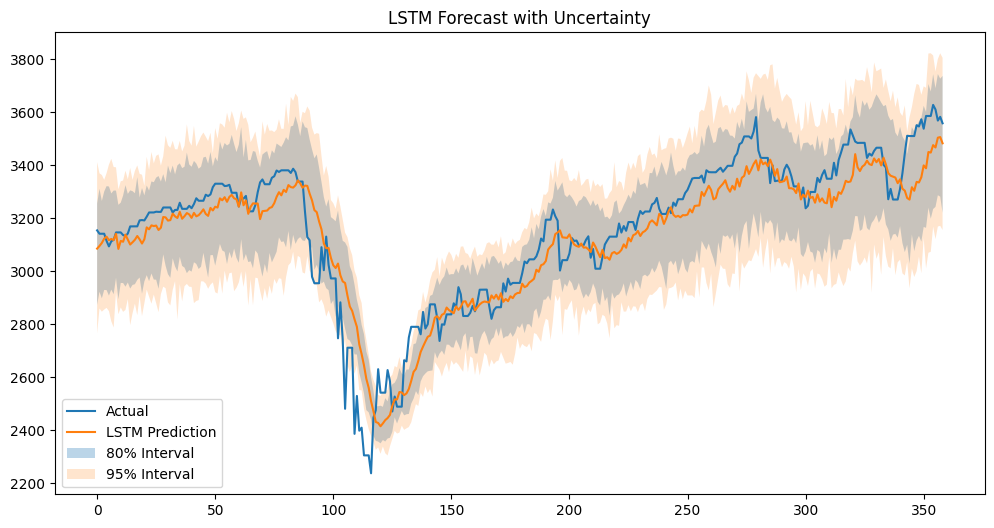

In [6]:
#task:
#step1: import & setup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

from statsmodels.tsa.arima.model import ARIMA

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

#Step2: load and dataset
df = pd.read_csv("/content/time series data set(in).csv")   # your dataset file
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')

series = df[['Close']].values

#step3: Train &test spilt

train_size = int(len(series) * 0.8)
train, test = series[:train_size], series[train_size:]

#Task2
# Step4:Basline model-arima
arima_model = ARIMA(train, order=(1,1,1))
arima_fit = arima_model.fit()

arima_forecast = arima_fit.forecast(steps=len(test))

arima_rmse = np.sqrt(mean_squared_error(test, arima_forecast))
arima_mae = mean_absolute_error(test, arima_forecast)

print("ARIMA RMSE:", arima_rmse)
print("ARIMA MAE:", arima_mae)

#Step5: Scaling for LSTM(task1)

scaler = MinMaxScaler()
scaled_series = scaler.fit_transform(series)

# Step6: create LSTM Sequences
def create_sequences(data, window=30):
    X, y = [], []
    for i in range(window, len(data)):
        X.append(data[i-window:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

window_size = 30
X, y = create_sequences(scaled_series, window_size)

split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test  = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Step7:Optimized LSTM model
# Task3
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(window_size, 1)),
    Dropout(0.3),
    LSTM(32),
    Dropout(0.3),
    Dense(1)
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='mse'
)

es = EarlyStopping(patience=10, restore_best_weights=True)

model.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=100,
    batch_size=32,
    callbacks=[es],
    verbose=1
)

# Step8 :LSTM prediction & Accuracy
lstm_pred = model.predict(X_test)
lstm_pred_inv = scaler.inverse_transform(lstm_pred)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1,1))

lstm_rmse = np.sqrt(mean_squared_error(y_test_inv, lstm_pred_inv))
lstm_mae = mean_absolute_error(y_test_inv, lstm_pred_inv)

print("LSTM RMSE:", lstm_rmse)
print("LSTM MAE:", lstm_mae)

#Step9: Uncertainty quantification- monte carlo dropout(task4)

def mc_dropout_prediction(model, X, n_samples=100):
    preds = []
    for i in range(n_samples):
        preds.append(model(X, training=True).numpy())
    return np.array(preds)

mc_preds = mc_dropout_prediction(model, X_test, n_samples=100)
mc_preds_inv = scaler.inverse_transform(mc_preds.reshape(-1,1))
mc_preds_inv = mc_preds_inv.reshape(100, -1)

y_true = scaler.inverse_transform(y_test.reshape(-1,1)).flatten()
mean_pred = mc_preds_inv.mean(axis=0)
lower_80 = np.percentile(mc_preds_inv, 10, axis=0)
upper_80 = np.percentile(mc_preds_inv, 90, axis=0)

lower_95 = np.percentile(mc_preds_inv, 2.5, axis=0)
upper_95 = np.percentile(mc_preds_inv, 97.5, axis=0)

coverage_80 = np.mean((y_true >= lower_80) & (y_true <= upper_80))
coverage_95 = np.mean((y_true >= lower_95) & (y_true <= upper_95))

print("80% coverage probability:", coverage_80)
print("95% coverage probability:", coverage_95)

mean_width_80 = np.mean(upper_80 - lower_80)
mean_width_95 = np.mean(upper_95 - lower_95)

print("80% mean width:", mean_width_80)
print("95% mean width:", mean_width_95)

# step10:Final Visualization(task10)
plt.figure(figsize=(12,6))
plt.plot(y_test_inv, label="Actual")
plt.plot(mean_pred, label="LSTM Prediction")

plt.fill_between(range(len(mean_pred)), lower_80, upper_80,
                 alpha=0.3, label="80% Interval")
plt.fill_between(range(len(mean_pred)), lower_95, upper_95,
                 alpha=0.2, label="95% Interval")

plt.legend()
plt.title("LSTM Forecast with Uncertainty")
plt.show()